In [ ]:
# https://towardsdatascience.com/lstm-framework-for-univariate-time-series-prediction-d9e7252699e

Summary Statistics - ADF Test For Stationarity

P Value is high. Consider Differencing: 0.276771414461377
Epoch 1/201
29/29 [==============================] - 6s 93ms/step - loss: 0.0394 - val_loss: 0.0551 - lr: 0.0010
Epoch 2/201
29/29 [==============================] - 2s 74ms/step - loss: 0.0287 - val_loss: 0.0604 - lr: 0.0010
Epoch 3/201
29/29 [==============================] - 2s 68ms/step - loss: 0.0244 - val_loss: 0.0427 - lr: 0.0010
Epoch 4/201
29/29 [==============================] - 2s 68ms/step - loss: 0.0222 - val_loss: 0.0432 - lr: 0.0010
Epoch 5/201
29/29 [==============================] - 2s 69ms/step - loss: 0.0231 - val_loss: 0.0432 - lr: 0.0010
Epoch 6/201
29/29 [==============================] - 2s 69ms/step - loss: 0.0220 - val_loss: 0.0447 - lr: 0.0010
Epoch 7/201
29/29 [==============================] - 2s 69ms/step - loss: 0.0223 - val_loss: 0.0474 - lr: 0.0010
Epoch 8/201
29/29 [==============================] - 2s 70ms/step - loss: 0.0223 - val_loss: 0.0436 - l

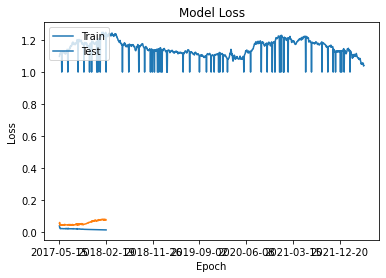

See Plot for predicted vs. actuals


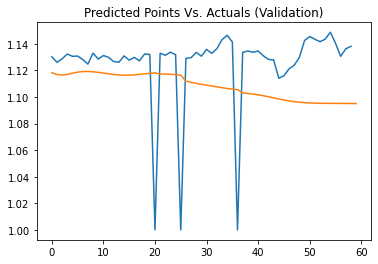

Validation Vs. Predicted
Validation    65.166900
Predicted     66.490769
dtype: float64
See Plot for Future Predictions


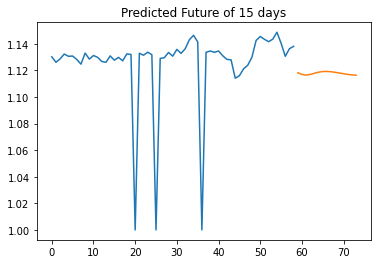

,perc,historical_flag
59,1.118223,0
60,1.116957,0
61,1.116474,0
62,1.116939,0
63,1.117863,0
64,1.118672,0
65,1.119147,0
66,1.119210,0
67,1.118971,0
68,1.118543,0


In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import LSTM_Prep

# Data
dat = pd.read_csv('LSTM_tutorial3.csv')

split = 0.8
sequence_length = 60

data_prep = LSTM_Prep.Data_Prep(dataset = dat)
rnn_df, validation_df = data_prep.preprocess_rnn(date_colname = 'date', numeric_colname = 'perc', pred_set_timesteps = 60)


series_prep = LSTM_Prep.Series_Prep(rnn_df =  rnn_df, numeric_colname = 'perc')
window, X_min, X_max = series_prep.make_window(sequence_length = sequence_length, 
                                               train_test_split = split, 
                                               return_original_x = True)

X_train, X_test, y_train, y_test = series_prep.reshape_window(window, train_test_split = split)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
#                 Building the LSTM
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ReduceLROnPlateau #Learning rate scheduler for when we reach plateaus
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)

# Reset model if we want to re-train with different splits
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)  


# Epochs and validation split
EPOCHS = 201
validation = 0.05

# Instantiate the model
model = Sequential()

# Add the first layer.... the input shape is (Sample, seq_len-1, 1)
model.add(LSTM(
        input_shape = (sequence_length-1, 1), return_sequences = True,
        units = 100))

# Add the second layer.... the input shape is (Sample, seq_len-1, 1)
model.add(LSTM(
        input_shape = (sequence_length-1, 1), 
        units = 100))

# Add the output layer, simply one unit
model.add(Dense(
        units = 1,
        activation = 'sigmoid'))

model.compile(loss = 'mse', optimizer = 'adam')


# History object for plotting our model loss by epoch
history = model.fit(X_train, y_train, epochs = EPOCHS, validation_split = validation,
          callbacks = [rlrop])
# Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
#              Predicting the future
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# Creating our future object
future = LSTM_Prep.Predict_Future(X_test  = X_test, validation_df = validation_df, lstm_model = model)
# Checking its accuracy on our training set
future.predicted_vs_actual(X_min = X_min, X_max = X_max, numeric_colname = 'perc')
# Predicting 'x' timesteps out
future.predict_future(X_min = X_min, X_max = X_max, numeric_colname = 'perc', timesteps_to_predict = 15, return_future = True)